In [0]:
!pip install wget

import os
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import keras
import random
import wget

from keras.preprocessing.image import img_to_array, load_img

plt.style.use('ggplot')

%matplotlib inline

In [0]:
# COLAB-ONLY: load/save content from drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

save_path = "/content/gdrive/My Drive/modelli/keras" 

def save_in_drive(fname, content):
  with open(f'{save_path}/{fname}', 'w') as f:
    f.write(content)
    
def load_from_drive(fname):
  with open(f'{save_path}/{fname}', 'r') as f:
    return f.read()

Mounted at /content/gdrive


# 1. Dataset
---
* Download, unzip and load CelebA
* Optionally download LFW

In [0]:
# ------------------------------------------------------------------------------
# -- Downloading CelebA
# ------------------------------------------------------------------------------

!pip install kaggle

os.environ['KAGGLE_USERNAME'] = "lucaanzalone"
os.environ['KAGGLE_KEY'] = "906701c2b9665f810d3c81f810391c89"

!kaggle datasets download -d jessicali9530/celeba-dataset

In [0]:
# ------------------------------------------------------------------------------
# -- unzipping and storing to 'celeba-folder'
# ------------------------------------------------------------------------------

import zipfile

def extract(path, folder):
  zip_ref = zipfile.ZipFile(path, 'r')
  zip_ref.extractall(folder)
  zip_ref.close()

base_folder = 'celeba-dataset'
extract(base_folder + ".zip", base_folder)

for file in os.listdir(base_folder):
  name, ext = os.path.splitext(file)
  if ext == ".zip":
    extract(os.path.join(base_folder, file), base_folder)

In [0]:
# ------------------------------------------------------------------------------
# -- LFW
# ------------------------------------------------------------------------------

lfw_folder = 'lfw'

# download
wget.download('http://vis-www.cs.umass.edu/lfw/lfw.tgz', 'lfw.tgz')

# extract
!tar -zxvf lfw.tgz

In [0]:
import shutil

def flatten_directory(root):
  for folder in os.listdir(root):
    subdir = os.path.join(root, folder)

    if os.path.isdir(subdir):
      for item in os.listdir(subdir):
        src = os.path.join(subdir, item)
        dst = os.path.join(root, item)
        shutil.move(src, dst)
      
      os.rmdir(subdir)

# remove subdirectories:
flatten_directory('./lfw')

In [0]:
# ------------------------------------------------------------------------------
# -- CelebA Class:
# ------------------------------------------------------------------------------

class CelebA():
  '''Wraps the celebA dataset, allowing an easy way to:
       - Select the features of interest,
       - Split the dataset into 'training', 'test' or 'validation' partition.
  '''
  def __init__(self, main_folder='celeba-dataset/', selected_features=None, drop_features=[]):
    self.main_folder = main_folder
    self.images_folder   = os.path.join(main_folder, 'img_align_celeba/')
    self.attributes_path = os.path.join(main_folder, 'list_attr_celeba.csv')
    self.partition_path  = os.path.join(main_folder, 'list_eval_partition.csv')
    self.selected_features = selected_features
    self.features_name = []
    self.__prepare(drop_features)

  def __prepare(self, drop_features):
    '''do some preprocessing before using the data: e.g. feature selection'''
    # attributes:
    if self.selected_features is None:
      self.attributes = pd.read_csv(self.attributes_path)
      self.num_features = 40
    else:
      self.num_features = len(self.selected_features)
      self.selected_features = self.selected_features.copy()
      self.selected_features.append('image_id')
      self.attributes = pd.read_csv(self.attributes_path)[self.selected_features]

    # remove unwanted features:
    for feature in drop_features:
      if feature in self.attributes:
        self.attributes = self.attributes.drop(feature, axis=1)
        self.num_features -= 1
      
    self.attributes.set_index('image_id', inplace=True)
    self.attributes.replace(to_replace=-1, value=0, inplace=True)
    self.attributes['image_id'] = list(self.attributes.index)
  
    self.features_name = list(self.attributes.columns)[:-1]
  
    # load ideal partitioning:
    self.partition = pd.read_csv(self.partition_path)
    self.partition.set_index('image_id', inplace=True)
  
  def split(self, name='training', drop_zero=False):
    '''Returns the ['training', 'validation', 'test'] split of the dataset'''
    # select partition split:
    if name is 'training':
      to_drop = self.partition.where(lambda x: x != 0).dropna()
    elif name is 'validation':
      to_drop = self.partition.where(lambda x: x != 1).dropna()
    elif name is 'test':  # test
      to_drop = self.partition.where(lambda x: x != 2).dropna()
    else:
      raise ValueError('CelebA.split() => `name` must be one of [training, validation, test]')

    partition = self.partition.drop(index=to_drop.index)
      
    # join attributes with selected partition:
    joint = partition.join(self.attributes, how='inner').drop('partition', axis=1)

    if drop_zero is True:
      # select rows with all zeros values
      return joint.loc[(joint[self.features_name] == 1).any(axis=1)]
    elif 0 <= drop_zero <= 1:
      zero = joint.loc[(joint[self.features_name] == 0).all(axis=1)]
      zero = zero.sample(frac=drop_zero)
      return joint.drop(index=zero.index)

    return joint


In [0]:
# loading dataset:

celeba = CelebA(drop_features=[
    'Attractive',
    'Pale_Skin',
    'Blurry',
])

# 2. Load Model
---
* Load the model to infer facial features

In [0]:
model = keras.models.load_model(f"{save_path}/UL19/weights-FC37-MobileNetV2-0.92.hdf5")

# model.summary()

In [0]:
#@title Model Input Image Format
img_size = 224 #@param ["224", "192"] {type:"raw"}

# default is 224
IMG_W = img_size
IMG_H = img_size
IMG_SHAPE = (IMG_H, IMG_W, 3)
TARGET_SIZE = (IMG_H, IMG_W)

# 3. Preparing the Data
---
* Selecting the facial attributes
* Loading the data (from various sources)

In [0]:
# ------------------------------------------------------------------------------
# -- Maps: feature_name -> index, and index -> feature_name
# ------------------------------------------------------------------------------

dict_feature_name_to_index = { name: i for i, name in enumerate(celeba.features_name) }
dict_index_to_feature_name = { v: k for k, v in dict_feature_name_to_index.items() }

def features_to_indexes(features_name):
  '''From a feature_name returns an index.
     Example: 'Bangs' -> 4
  '''
  indexes = []
  
  for name in features_name:
    indexes.append(dict_feature_name_to_index[name])
  
  return indexes


def indexes_to_features(feature_indexes):
  '''From a feature_index returns its name.
     Example: 4 -> 'Bangs'
  '''
  features_name = []
  
  for index in feature_indexes:
    features_name.append(dict_index_to_feature_name[index])
  
  return features_name

In [0]:
def image_paths_from_folder(folder, amount=-1):
  '''From a given folder returns an array of images' path.
     Set amount > 0 to limit the number of path taken.
  
     Supports images with extendsion: '.jpeg', '.jpg' and '.png'
  '''
  assert(folder is not None)
  
  paths = []
  count = 0
  
  for file in os.listdir(folder):
    # select only images
    if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
      paths.append(os.path.join(folder, file))
      count += 1
      
      if count == amount:
        break
      
  return paths



def load_reshape_img(fname, shape):
  img = load_img(fname, target_size=shape)
  x = img_to_array(img) / 255.0
  x = x.reshape(x.shape)
  return x


def infere_labels(model, paths):
  '''Use the given model to predict the images features.
     The images are loaded from the given paths.
     
     Returns an array of array of features.
  '''
  assert(model is not None)
  # first load images
  image_batch = []
  
  for path in paths:
    img = load_reshape_img(path, TARGET_SIZE)
    image_batch.append(img)
    
  # predict labels: batch_size will handle large amount of images
  preds = model.predict(np.array(image_batch), batch_size=64, verbose=1)
  
  # convert labels to 0, 1 integers.
  preds = np.round(preds).astype('int')  
  return preds


def dataframe_from_folder_or_labels(features_name, folder, labels=None, model=None, amount=-1):
  '''Organize images and feature-labes in a DataFrame.
       - If labels are given it will take that instead, it uses the model to 
         infere the images's labels.
       - Use amount to limit the number of images (and so predictions)
       
     Returns a pandas data-frame indexed by 'image_path'.
  '''
  paths = image_paths_from_folder(folder, amount)
  labels = labels or infere_labels(model, paths)
  indexes = features_to_indexes(features_name)
  
  df = pd.DataFrame()
  df['image_path'] = paths
  df.set_index('image_path', inplace=True)
  
  # select features for every image
  for i, name in enumerate(features_name):
    column = []
    
    for j, features in enumerate(labels):
      column.append(features[indexes[i]])
    df[name] = column
  
#   # take features
  img_features = []
  for features in labels:
    features_ = []
    
    for i, name in enumerate(features_name):
      features_.append(features[indexes[i]])
    img_features.append(features_)
  
  # set a column with the selected features
  df['features'] = img_features
  
  return df

In [0]:
# ------------------------------------------------------------------------------
# -- Attribute selection:
# ------------------------------------------------------------------------------

# we can pick any feature, as an example we select these:
chosen_features = [
   'Wearing_Lipstick',
   'Smiling',               
   'No_Beard',             
   'Heavy_Makeup',
   'Bald',
   'Male',           
   'Young',
   'Eyeglasses',
   'Blond_Hair',
   'Wearing_Hat'
]

chose_features_indexes = features_to_indexes(chosen_features)

print(f"selected featrues: {chosen_features}")
print(f"features indexes: {chose_features_indexes}")

selected featrues: ['Wearing_Lipstick', 'Smiling', 'No_Beard', 'Heavy_Makeup', 'Bald', 'Male', 'Young', 'Eyeglasses', 'Blond_Hair', 'Wearing_Hat']
features indexes: [33, 28, 22, 16, 3, 18, 36, 13, 8, 32]


In [0]:
# ------------------------------------------------------------------------------
# -- Loading data from CelebA
# ------------------------------------------------------------------------------

# Pick 400 samples sampled from 2000 instances. 
# Let the model infer the selected features

celeba_df = dataframe_from_folder_or_labels(chosen_features, celeba.images_folder,  model=model, amount=2000)
celeba_df = celeba_df.sample(400, random_state=51)

celeba_df.head()

2000/2000 [==============================] - 8s 4ms/step


Wearing_Lipstick  ...                        features
image_path                                                    ...                                
celeba-dataset/img_align_celeba/113994.jpg                 0  ...  [0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
celeba-dataset/img_align_celeba/072306.jpg                 1  ...  [1, 1, 1, 1, 0, 0, 1, 0, 0, 0]
celeba-dataset/img_align_celeba/148099.jpg                 1  ...  [1, 1, 1, 1, 0, 0, 1, 0, 0, 0]
celeba-dataset/img_align_celeba/003463.jpg                 1  ...  [1, 0, 1, 1, 0, 0, 1, 0, 0, 0]
celeba-dataset/img_align_celeba/096923.jpg                 1  ...  [1, 0, 1, 1, 0, 0, 1, 0, 0, 0]

[5 rows x 11 columns]

In [0]:
# ------------------------------------------------------------------------------
# -- Loading data from LFW
# ------------------------------------------------------------------------------

# we do the same as before but with a different data-source:

lfw_df = dataframe_from_folder_or_labels(chosen_features, "lfw",  model=model, amount=500)
lfw_df = lfw_df.sample(100, random_state=51)

lfw_df.head()

500/500 [==============================] - 1s 2ms/step


Wearing_Lipstick  ...                        features
image_path                                       ...                                
lfw/Julie_Gerberding_0004.jpg                 1  ...  [1, 0, 1, 1, 0, 0, 1, 0, 0, 0]
lfw/Abdullah_Nasseef_0001.jpg                 0  ...  [0, 0, 0, 0, 1, 1, 0, 0, 0, 0]
lfw/Eric_Clapton_0001.jpg                     0  ...  [0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
lfw/Laura_Bush_0031.jpg                       1  ...  [1, 1, 1, 1, 0, 0, 1, 0, 0, 0]
lfw/Colin_Powell_0133.jpg                     0  ...  [0, 0, 1, 0, 0, 1, 0, 1, 0, 0]

[5 rows x 11 columns]

In [0]:
# ------------------------------------------------------------------------------
# -- Merge data into one data-frame
# ------------------------------------------------------------------------------

# before doing clustering on these data, we need to merge every df:
data_df = celeba_df.append(lfw_df)

# show 10 random samples
data_df.sample(10)

Wearing_Lipstick  ...                        features
image_path                                                    ...                                
celeba-dataset/img_align_celeba/166118.jpg                 0  ...  [0, 0, 1, 0, 0, 1, 1, 0, 0, 0]
celeba-dataset/img_align_celeba/155532.jpg                 1  ...  [1, 1, 1, 1, 0, 0, 1, 0, 0, 0]
celeba-dataset/img_align_celeba/142519.jpg                 0  ...  [0, 1, 1, 0, 0, 0, 1, 0, 0, 1]
celeba-dataset/img_align_celeba/060664.jpg                 0  ...  [0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
celeba-dataset/img_align_celeba/145594.jpg                 0  ...  [0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
celeba-dataset/img_align_celeba/012933.jpg                 0  ...  [0, 0, 0, 0, 0, 1, 1, 1, 0, 0]
lfw/George_W_Bush_0147.jpg                                 0  ...  [0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
celeba-dataset/img_align_celeba/161628.jpg                 0  ...  [0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
celeba-dataset/img_align_celeba/170480.jpg                 0  ...  [0, 1, 1, 0, 0, 1, 0, 1, 0, 0]
celeba-dataset/img_align_celeba/178361.jpg                 0  ...  [0, 1, 1, 0, 0, 1, 0, 0, 0, 0]

[10 rows x 11 columns]

# 4. Clustering
---
* KMeans
* Plot clusters
* Summarize clusters
* Weighted Clustering

In [0]:
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.cluster import SpectralClustering, OPTICS, Birch
from sklearn.metrics import silhouette_score
from math import sqrt


def score(method, features):
  print(f'Score with {n_clusters} clusters is {-method.inertia_}')
  
def silhouette(features, labels):
  print(f'silhouette_score: {silhouette_score(features, labels)} for {n_clusters} clusters')

  
def resize(image, shape):
  return cv2.resize(image, shape)

def imread(path, shape=None):
  img = cv2.imread(path, cv2.IMREAD_COLOR)
  
  if shape is not None:
    img = resize(img, shape)
    
  return img

def labels_to_indices(labels):
  '''Convert a list of cluster-labels into a dict of indices organized by
     cluster-id, including the noise claster (the one -1 labelled).
     
     Example: 
       - labels = [0, 1, 1, 0, 2, 2]
       - returns -> { 0: [0, 3], 1: [1, 2], 2: [4, 5] }
  '''
  indices  = dict()
  
  for cluster_id in set(labels):
    indices[cluster_id] = []
  
  for i, label in enumerate(labels):
    indices[label].append(i)
  
  return indices

In [0]:
# ------------------------------------------------------------------------------
# -- Cluster and Clustering utility class
# ------------------------------------------------------------------------------

class Cluster:
  '''A Single cluster with:
      - k: as cluster identifier,
      - features: of the items inside this cluster,
      - paths: of the images related to the items in the cluster.
  '''
  def __init__(self, k, features, paths):
    if len(features) != len(paths):
      raise ValueError("Size of [features] and [paths] parameters must be the same!")
    
    self.k = k
    self.features = features
    self.paths = paths
    self.size = len(paths)
    self.image = None
    self.eigenface = None
  
  def get_image(self, img_size=200, rows=None, cols=None):
    '''Returns an image that represents all cluster's items.
        - It caches the returned image for later reuse.
        - The returned image is in RGB format.
    '''
    if self.image is not None:
      return self.image
    
    if (rows is None) or (cols is None):
      rows = int(sqrt(self.size))
      cols = rows
      
    h, w = img_size, img_size
    image = np.zeros(shape=(h * rows, h * cols, 3), dtype=np.uint8)
      
    k = 0
    for i in range(rows):
      r = i * h
      for j in range(cols):
        c = j * w
        img = imread(self.paths[k], shape=(w, h))
        image[r:r+w, c:c+w] = img
        
        k = k + 1
        if k > self.size:
          break

    self.image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return self.image
  
  def plot(self, img_size=200, dpi=100, rows=None, cols=None):
    '''Visualize the images in this cluster.
        - img_size: specify the squared-size of a single image.
        - dpi: resolution of the plt.figure plot.
        - rows: amount of images in row.
        - cols: amount of images on columns.
    '''
    image = self.get_image(img_size, rows, cols)
    
    plt.figure(dpi=dpi)
    plt.imshow(image)
    plt.grid(False)
    
  def __len__(self):
    return self.size
      
  def features_frequency(self):
    '''Compute the frequency of every feature according to the items 
       within the cluster.
    '''
    num = len(self.features[0])
    frequencies = np.zeros(num)
      
    for features in self.features:
      frequencies += features
      
    return np.round(frequencies / self.size, 2)

  def get_eigenface(self, w=200, h=200, components=None):
    '''Computes the average-face of this Cluster'''
    if self.eigenface is not None:
      return self.eigenface
    
    if components is None:
      components = self.size
    
    # load flat images into a matrix
    data = np.zeros((self.size, h * w * 3), dtype=np.float32)
    
    for i in range(self.size):
      img = imread(self.paths[i], shape=(h, w))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.
      data[i, :] = img.flatten()
      
    # get eigen-vectors from the images
    mean, eigenvectors = cv2.PCACompute(data, mean=None, maxComponents=components)
    
    self.eigenface = mean.reshape((h, w, 3))
    return self.eigenface
  

class Clustering:
  '''Helpers for easy clustering'''
  def __init__(self, Method): 
    self.method = Method
    self.result = None
    self.features = None
    self.labels = None
    self.num_clusters = None
  
  def fit(self, df, features_weights=None, verbose=False):
    '''Fits the given dataframe [df] using the given [Method].
        - The df dataframe must have an 'image_path' and 'features' columns.
        - The Method can be whatever instance of: KMeans, DBScan, etc.
        - feature_weights: can be used to give more/less importance to features.
        
       Returns an array of k Cluster instances.
    '''
    clusters = []
    features = df['features'].to_list()
    features = np.array(features)
    
    if features_weights is None:
      features_weights = np.ones(features.shape, dtype=np.float32)
    
    # fit features (viewed as n-dimensional points)
    result = self.method.fit(features * features_weights)
    
    # get clustering info
    labels = result.labels_
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_amount = list(labels).count(-1)  # count the occurrencies of '-1'
    
    # save as last fit
    self.result = result
    self.labels = labels
    self.features = features
    self.num_clusters = num_clusters
    
    if verbose is True:
      print(f'Estimated number of clusters: {num_clusters}')
      print(f'Estimated number of noise points: {noise_amount}')
    
    # for every cluster, get the indexes of the belonging samples
    indices = labels_to_indices(labels)
    
    # build Cluster istances
    for k in range(num_clusters):
      # for every cluster k find the corresponding image paths and features
      df_slice = df.iloc[indices[k]]
      paths = list(df_slice.index)
      features = list(df_slice['features'].values)

      clusters.append(Cluster(k, features, paths))
    
    return clusters
  
  def evaluate(self):
    '''Evaluate the lastly done clustering. 
       It returns the silhouette_score og the clustering
    '''
    if self.result is None:
      raise ValueError("Fit data before evaluation!")
      
    return silhouette_score(self.features, self.labels)
  
  def plot(clusters, rows, cols, dpi=100):
    '''Shows the given clusters.
        - rows: number of rows in the subplot.
        - cols: nuber of columns in the subplot.
        - dpi: plt.figure resolution
    '''
    plt.figure(figsize=(20, 20), dpi=dpi)
    
    for i, cluster in enumerate(clusters):
      image = cluster.get_image()
      
      plt.subplot(rows, cols, i + 1)
      plt.title(f"Cluster {cluster.k}")
      plt.imshow(image)
      plt.grid(False)
      plt.tight_layout()
    
    _ = plt.show()

  def plot_with_frequencies(clusters, feature_names, dpi=100, figsize=(25, 25)):
    '''Shows the given clusters with the frequencies of the features within.
        - dpi: plot resolution (increase for a bigger plot)
    '''
    plt.figure(figsize=figsize, dpi=dpi)
    cols = 2
    rows = len(clusters)
    
    k = 1
    for i, cluster in enumerate(clusters):
      image = cluster.get_image()
      freqs = cluster.features_frequency()
      
      # cluster image
      plt.subplot(rows, cols, k)
      plt.title(f"Cluster {cluster.k}")
      plt.imshow(image)
      plt.grid(False)
      
      # frequency barplot
      plt.subplot(rows, cols, k + 1)
      plt.barh(feature_names, freqs, align='center')
      plt.xlabel('Features')
      plt.ylabel('Frequencies')
      plt.grid(False)
      plt.tight_layout()
      k += 2
      
    _ = plt.show()

  def plot_with_eigenfaces(clusters, dpi=100):
    '''Shows the given clusters along the cluster mean-face (eigenface).
         - dpi: plot resolution (increase for a bigger plot)
    '''
    plt.figure(figsize=(25, 25), dpi=dpi)
    cols = 2
    rows = len(clusters)
    
    k = 1
    for i, cluster in enumerate(clusters):
      image = cluster.get_image()
      eigenface = cluster.get_eigenface()
      
      # cluster image
      plt.subplot(rows, cols, k)
      plt.title(f"Cluster {cluster.k}")
      plt.imshow(image)
      plt.grid(False)
      
      # cluster eigenface
      plt.subplot(rows, cols, k + 1)
      plt.title(f"EigenFace {cluster.k}")
      plt.imshow(eigenface)
      plt.grid(False)
      k += 2
      
    _ = plt.show()
    
    
  def plot_all_stats(clusters, feature_names, dpi=100, figsize=(25, 25)):
    '''Shows the given clusters along with the: 
        - features frequency of every cluster, and
        - eigenface of every cluster.
    '''
    cols = 3
    rows = len(clusters)
    
    plt.figure(figsize=figsize, dpi=dpi)
    gs1 = gridspec.GridSpec(rows, cols)
    gs1.update(wspace=0, hspace=0)
    
    k = 1
    for i, cluster in enumerate(clusters):
      image = cluster.get_image()
      eigenface = cluster.get_eigenface()
      freqs = cluster.features_frequency()
      
      # cluster image
      ax1 = plt.subplot(rows, cols, k)
      plt.title(f"Cluster {cluster.k}")
      plt.imshow(image)
      plt.grid(False)
      ax1.set_aspect('equal')
      
      # cluster eigenface
      ax2 = plt.subplot(rows, cols, k + 1)
      plt.title(f"EigenFace {cluster.k}")
      plt.imshow(eigenface)
      plt.grid(False)
      ax2.set_aspect('equal')
      
      # frequency barplot
      ax3 = plt.subplot(rows, cols, k + 2)
      plt.barh(feature_names, freqs, align='center')
      plt.xlabel('Features')
      plt.ylabel('Frequencies')
      plt.grid(False)
      plt.tight_layout()
      k += 3
      
    _ = plt.show()

In [0]:
#@title Clustering Parameters
num_clusters = 16 #@param {type:"integer"}

# ------------------------------------------------------------------------------
# -- KMeans
# ------------------------------------------------------------------------------

kmeans = KMeans(n_clusters=num_clusters)
kmeans = Clustering(kmeans)

clusters = kmeans.fit(data_df, verbose=True)

# prints the goodness of the clustering (values close to 1 are better)
print(f"Clustering score: {kmeans.evaluate()}")

Estimated number of clusters: 16
Estimated number of noise points: 0
Clustering score: 0.6904372171250149


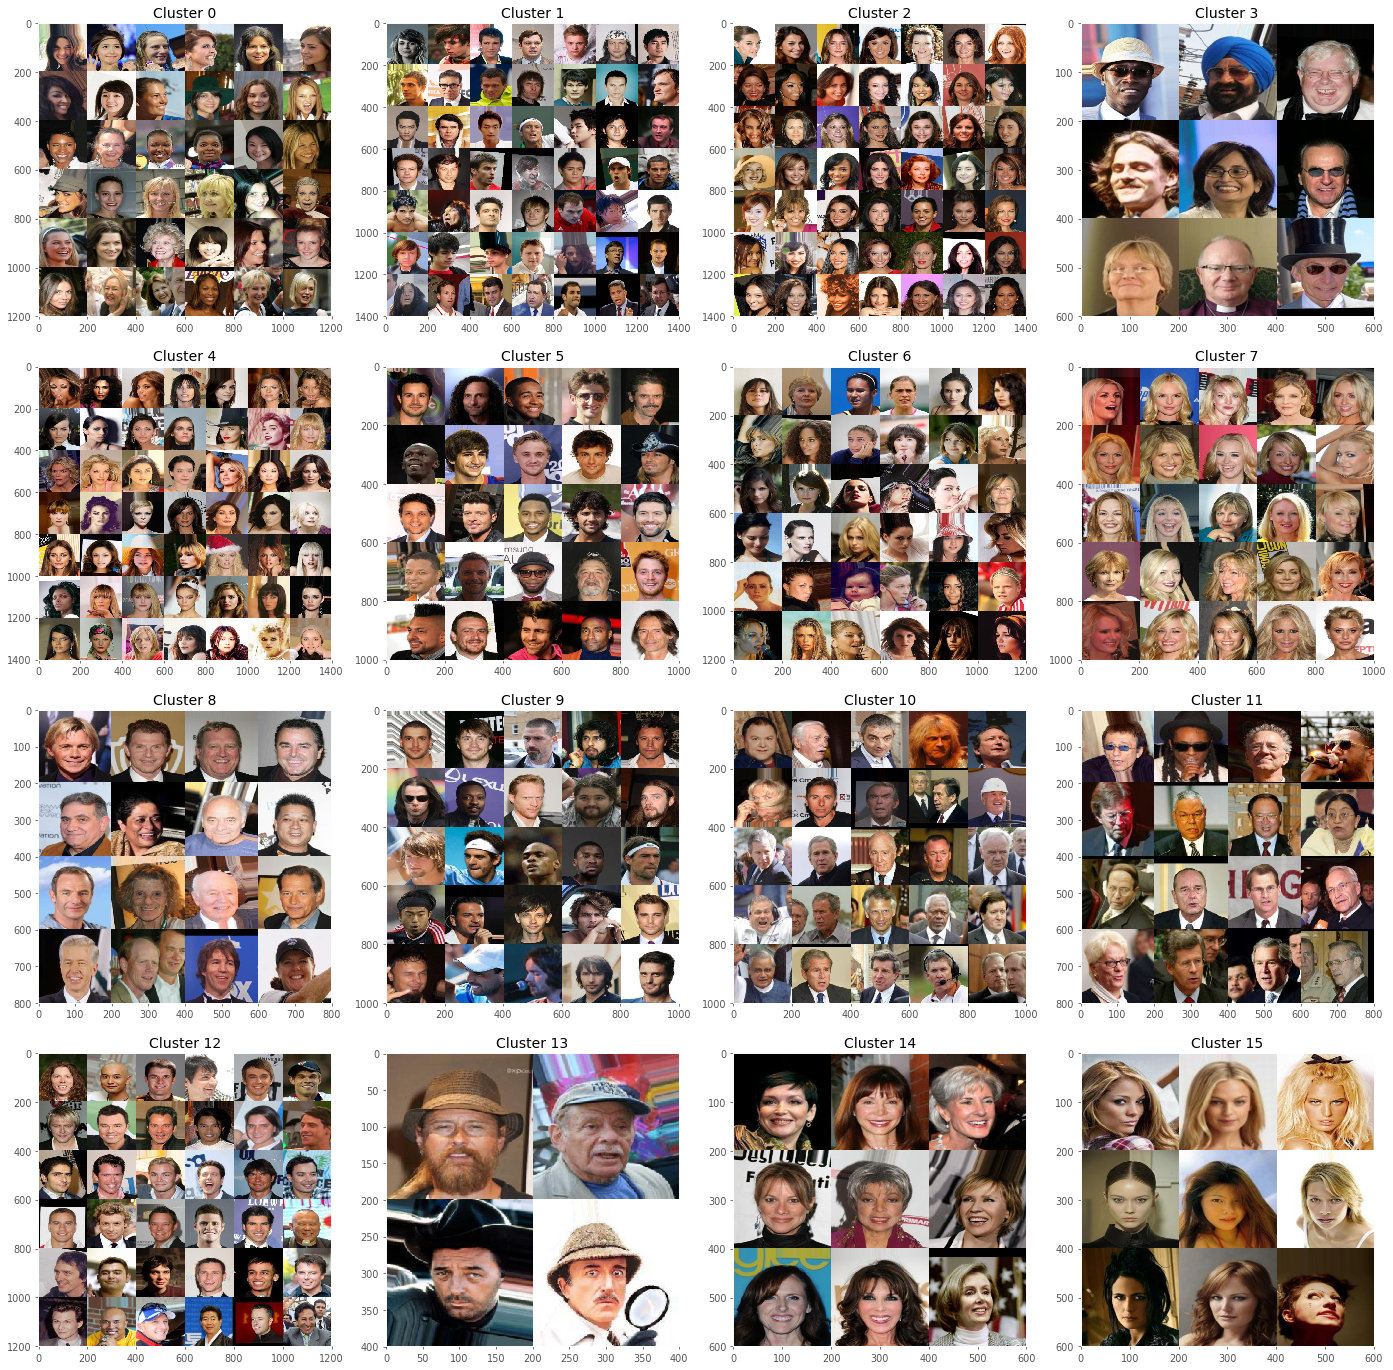

In [0]:
# ------------------------------------------------------------------------------
# -- Plot Clusters
# ------------------------------------------------------------------------------

Clustering.plot(clusters, rows=4, cols=4, dpi=70)

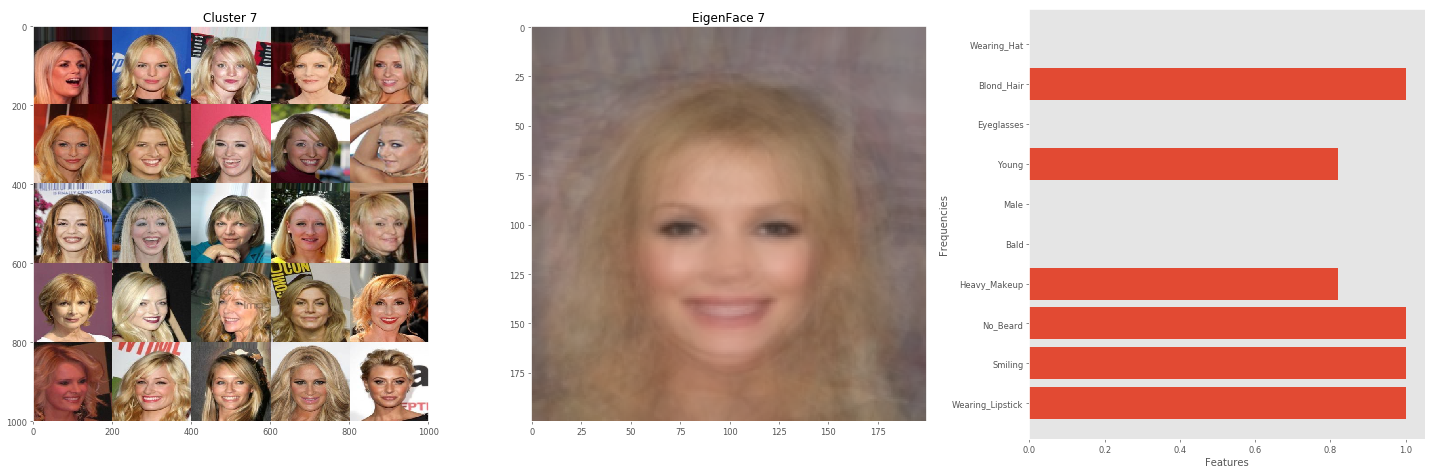

In [0]:
# ------------------------------------------------------------------------------
# -- More insight on Clustering
# ------------------------------------------------------------------------------

# plots: cluster image, attribute occurrences-chart, cluster eigenface
Clustering.plot_all_stats([clusters[7]], chosen_features, dpi=60, figsize=(24, 8))

# 1. The eigenface summarize the most common attributes in the cluster, by 
#    producing a synthesized face.

# 2. The attribute-occurrences chart shows the frequency of the single attributes.


In [0]:
# ------------------------------------------------------------------------------
# -- CelebA Attributes frequency
# ------------------------------------------------------------------------------

# pre-computed attributes frequency

attributes_frequency = np.array([
    0.11113579040370387 , 0.26698058726844653, 0.20457159215988233,
    0.022443348683853327, 0.15157527924619568, 0.24079585782753124, 
    0.23453225336748948 , 0.23925093411122464, 0.14799184596172735, 
    0.2051935103332198  , 0.14216753290983666, 0.05756691790186526, 
    0.046688285726977925, 0.06511878143524893, 0.06276437692189991, 
    0.041949861549168556, 0.38692194926924617, 0.45503186096673726, 
    0.41675427815537097 , 0.48342785502396357, 0.04154512115064734, 
    0.11514864337928618 , 0.8349399552811219 , 0.28414256733744986, 
    0.27744460732777554 , 0.07977828123534667, 0.06572095617451221, 
    0.05651064417889526 , 0.48208036564839907, 0.20840181837027824, 
    0.3195672239250934  , 0.1889249206560743 , 0.04846025893513788, 
    0.47243569810314956 , 0.12296704327267163, 0.07271506769529958, 
    0.773616849046639
])

# the same result can be obtained by this statement (but it take some time)
# attributes_frequency = celeba.attributes.mean(axis=0).values


# compute weights for rare and common occurring attributes
weights_rare_features = 1 - attributes_frequency + min(attributes_frequency)
weights_common_features = attributes_frequency + (1 - max(attributes_frequency))


print(f"rare weights:\n {weights_rare_features}\n")
print(f"common weights:\n {weights_common_features}")

rare weights:
 [0.91130756 0.75546276 0.81787176 1.         0.87086807 0.78164749
 0.7879111  0.78319241 0.8744515  0.81724984 0.88027582 0.96487643
 0.97575506 0.95732457 0.95967897 0.98049349 0.6355214  0.56741149
 0.60568907 0.53901549 0.98089823 0.90729471 0.18750339 0.73830078
 0.74499874 0.94266507 0.95672239 0.9659327  0.54036298 0.81404153
 0.70287612 0.83351843 0.97398309 0.55000765 0.89947631 0.94972828
 0.2488265 ]

common weights:
 [0.27619584 0.43204063 0.36963164 0.18750339 0.31663532 0.4058559
 0.3995923  0.40431098 0.31305189 0.37025356 0.30722758 0.22262696
 0.21174833 0.23017883 0.22782442 0.20700991 0.55198199 0.62009191
 0.58181432 0.6484879  0.20660517 0.28020869 1.         0.44920261
 0.44250465 0.24483833 0.230781   0.22157069 0.64714041 0.37346186
 0.48462727 0.35398497 0.2135203  0.63749574 0.28802709 0.23777511
 0.93867689]


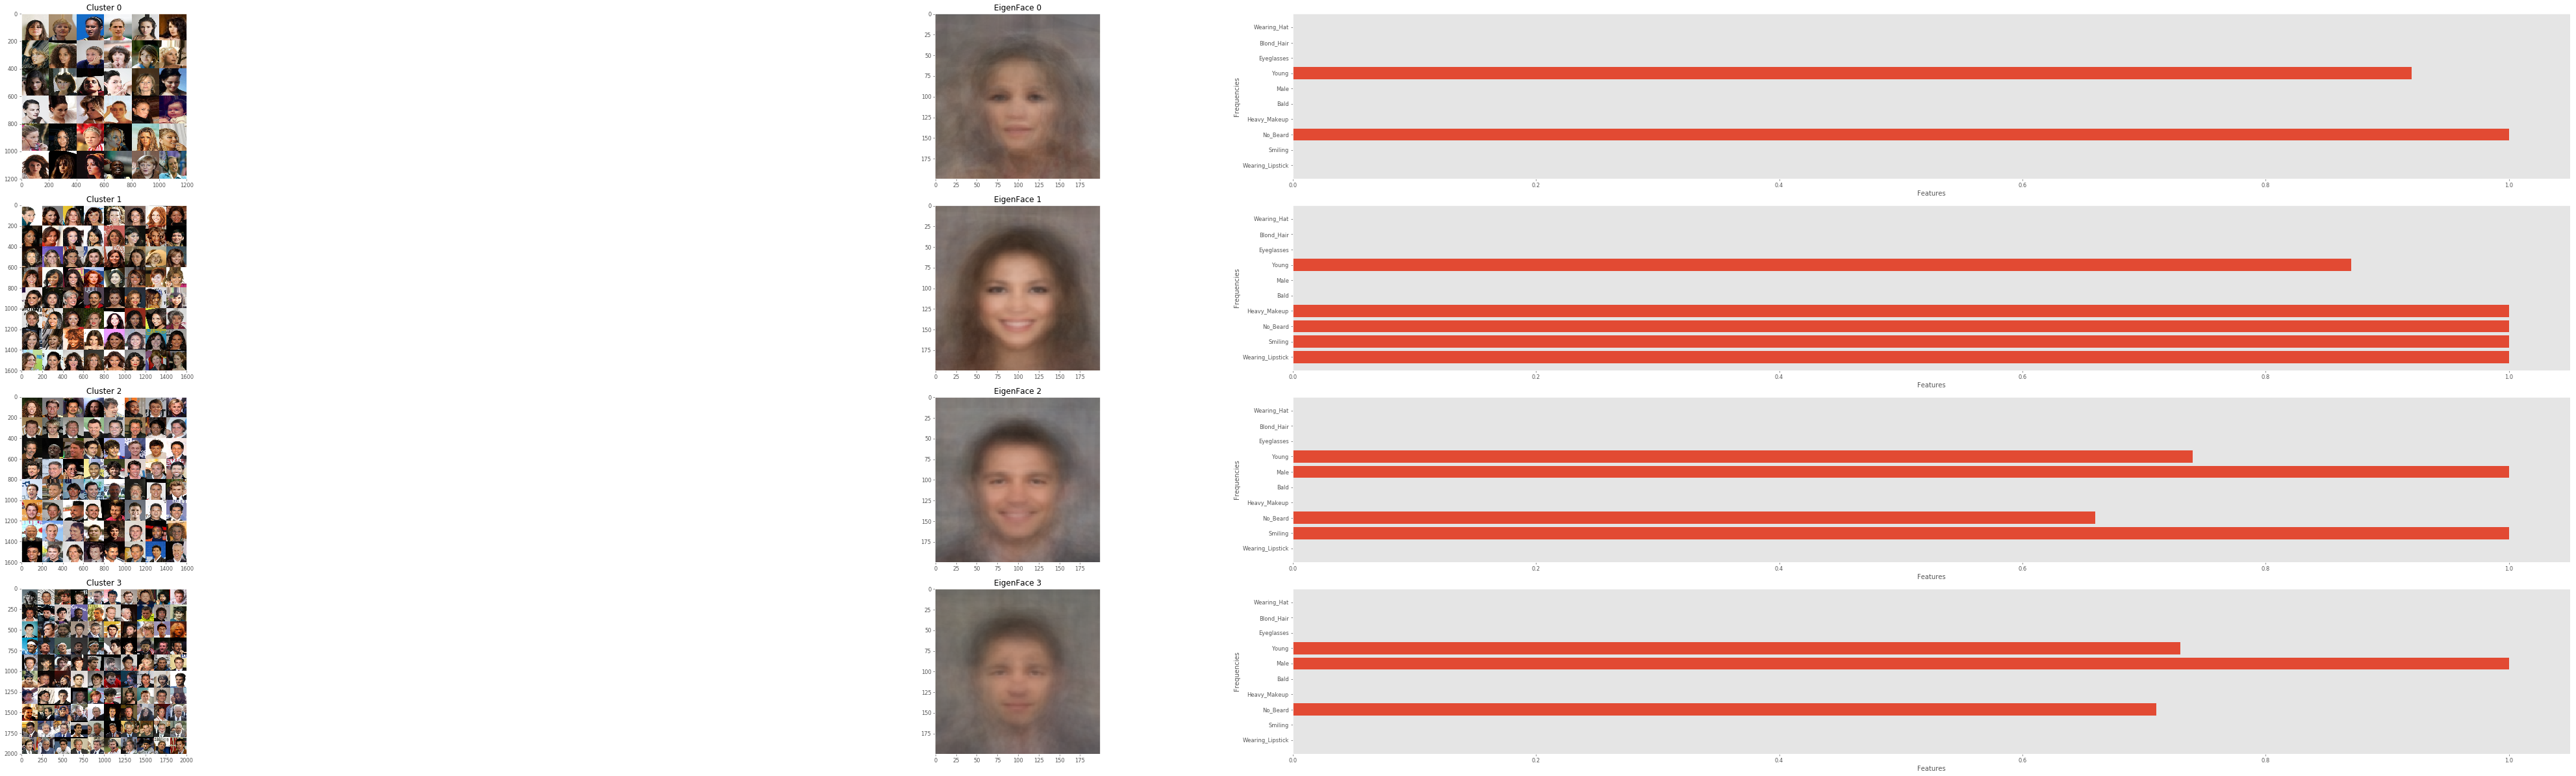

In [0]:
# ------------------------------------------------------------------------------
# -- Weighted Clustering: giving more importance to rare-occurring attributes
# ------------------------------------------------------------------------------

# get weights
rare_weights = []

for index in features_to_indexes(chosen_features):
  rare_weights.append(weights_rare_features[index])
  
# clustering:
rare_kmeans = Clustering(KMeans(n_clusters=num_clusters))
rare_clusters = rare_kmeans.fit(data_df, features_weights=rare_weights)

# plot first 4 clusters:
Clustering.plot_all_stats(rare_clusters[:4], chosen_features, dpi=60, figsize=(80, 20))

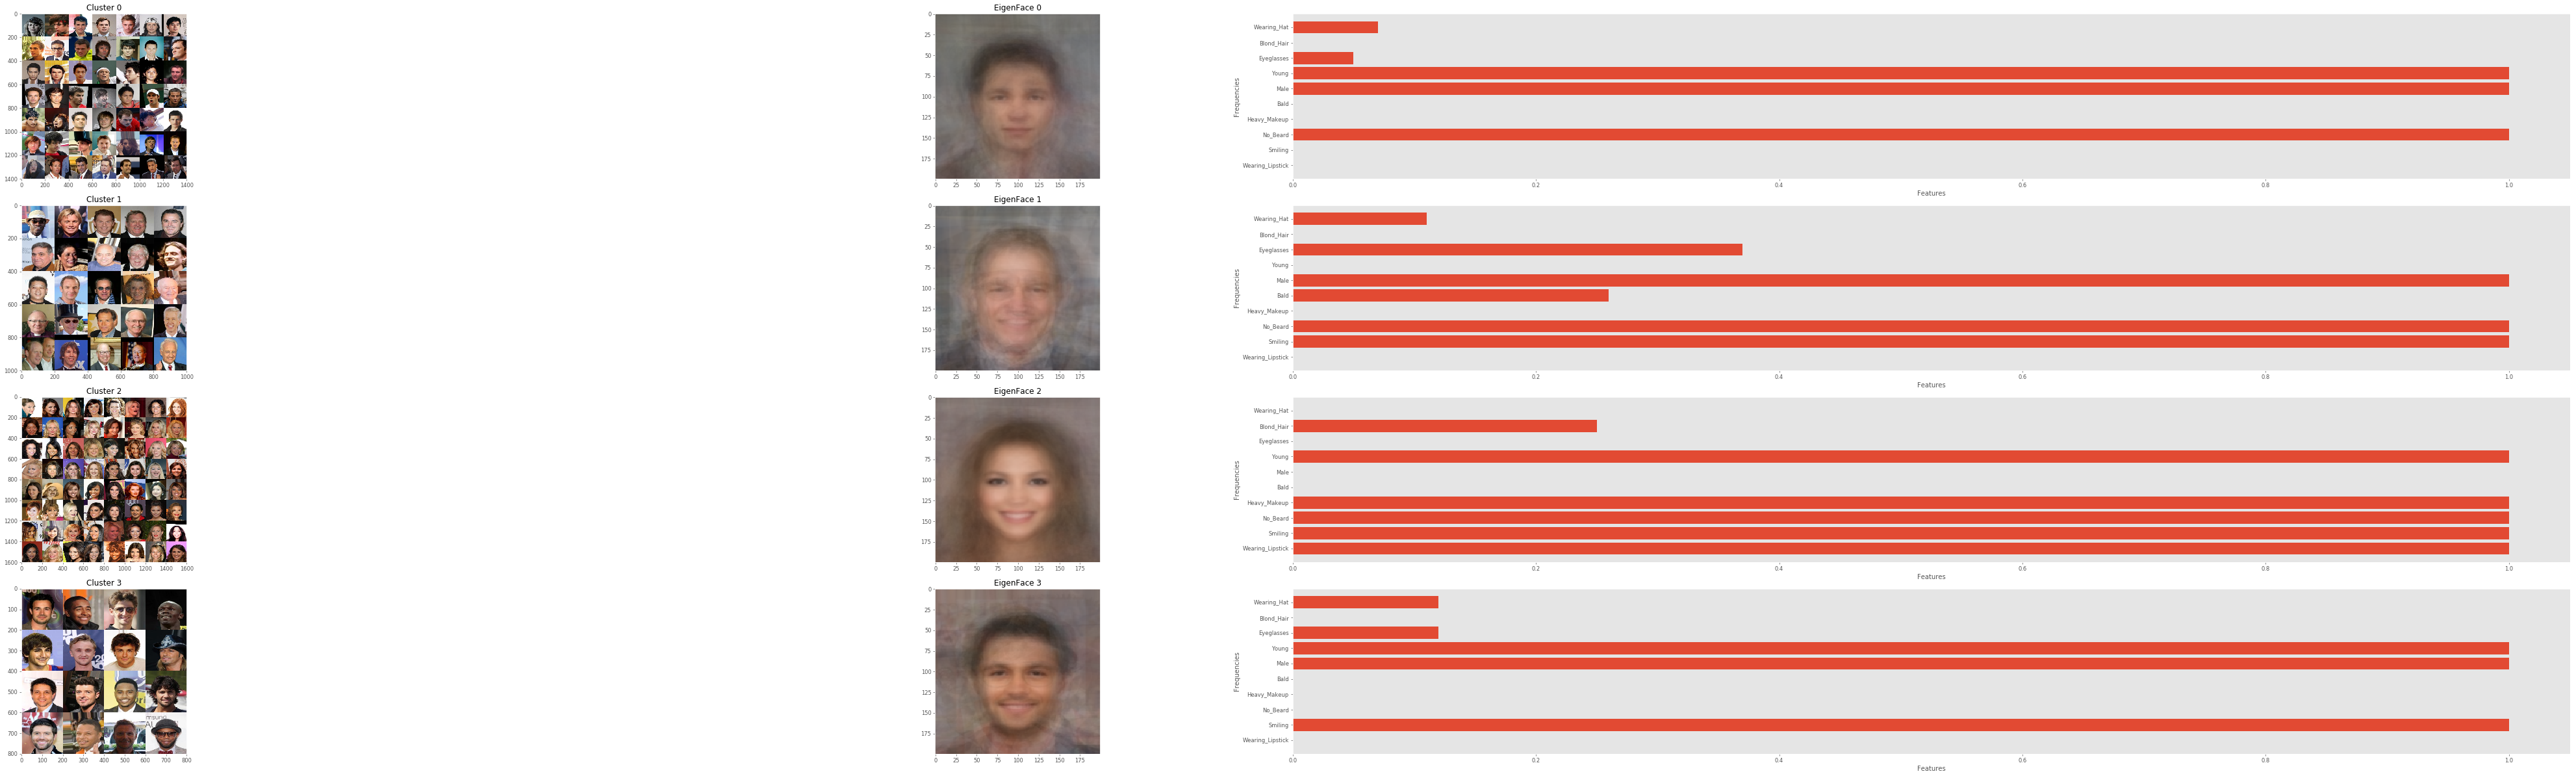

In [0]:
# ------------------------------------------------------------------------------
# -- Weighted Clustering: giving more importance to common-occurring attributes
# ------------------------------------------------------------------------------

# get weights
common_weights = []

for index in features_to_indexes(chosen_features):
  common_weights.append(weights_common_features[index])
  
# clustering:
common_kmeans = Clustering(KMeans(n_clusters=num_clusters
common_clusters = common_kmeans.fit(data_df, features_weights=common_weights)

# plot first 4 clusters:
Clustering.plot_all_stats(common_clusters[:4], chosen_features, dpi=60, figsize=(80, 20))

# 5. Methods Comparison
---
* Fixed-clusters (DBSCAN, OPTICS) vs variable-clusters (KMeans, Agglomerative, Spectral, Birch)

In [0]:
range_clusters = range(2, 51)

score = {
    'K-Means': [],
    'Agglomerative': [],
    'Birch': [],
    'Spectral': [],
    'DBSCAN': [],
    'OPTICS': [],
}

In [0]:
# ------------------------------------------------------------------------------
# -- KMeans Performance
# ------------------------------------------------------------------------------

for k in range_clusters:
  # fit data for k clusters
  kmeans = Clustering(KMeans(n_clusters=k, n_init=20, max_iter=500))
  kmeans.fit(data_df)
  
  # evaluate clustering through silhouette score
  score['K-Means'].append(kmeans.evaluate())


In [0]:
# ------------------------------------------------------------------------------
# -- AgglomerativeClustering Performance
# ------------------------------------------------------------------------------

for k in range_clusters:
  # fit data for k clusters
  agglomerative = Clustering(AgglomerativeClustering(n_clusters=k, 
                                                     affinity='manhattan', 
                                                     linkage='complete'))
  agglomerative.fit(data_df)
  
  # evaluate clustering through silhouette score
  score['Agglomerative'].append(agglomerative.evaluate())


In [0]:
# ------------------------------------------------------------------------------
# -- SpectralClustering Performance
# ------------------------------------------------------------------------------

for k in range_clusters:
  # fit data for k clusters
  spectral = Clustering(SpectralClustering(n_clusters=k))
  spectral.fit(data_df)
  
  # evaluate clustering through silhouette score
  score['Spectral'].append(spectral.evaluate())


In [0]:
# ------------------------------------------------------------------------------
# -- Birch Performance
# ------------------------------------------------------------------------------

for k in range_clusters:
  # fit data for k clusters
  birch = Clustering(Birch(n_clusters=k, threshold=0.36))
  birch.fit(data_df)
  
  # evaluate clustering through silhouette score
  score['Birch'].append(birch.evaluate())


In [0]:
# ------------------------------------------------------------------------------
# -- DBSCAN Performance
# ------------------------------------------------------------------------------

# DBSCAN 
dbscan = Clustering(DBSCAN(eps=.5, min_samples=3))
dbscan.fit(data_df)

score['DBSCAN'].append(dbscan.evaluate())

In [0]:
# ------------------------------------------------------------------------------
# -- OPTICS Performance
# ------------------------------------------------------------------------------

# OPTICS 
optics = Clustering(OPTICS(metric='hamming'))
optics.fit(data_df)

score['OPTICS'].append(optics.evaluate())

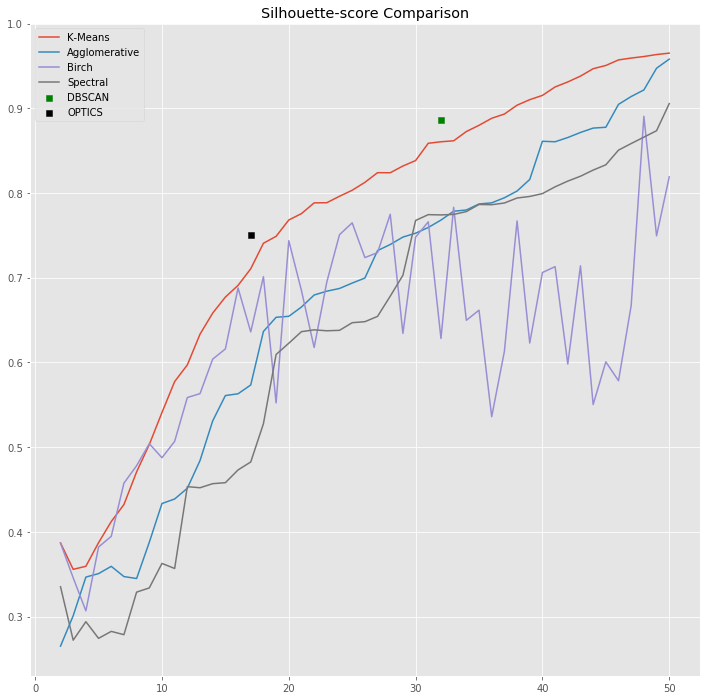

In [0]:
# ------------------------------------------------------------------------------
# -- Plot Comparison
# ------------------------------------------------------------------------------

x = list(range_clusters)

plt.figure(figsize=(12, 12))
plt.title('Silhouette-score Comparison')

# variable k methods
plt.plot(x, score['K-Means'])
plt.plot(x, score['Agglomerative'])
plt.plot(x, score['Spectral'])
plt.plot(x, score['Birch'])

# fixed k methods
plt.scatter([dbscan.num_clusters], score['DBSCAN'], marker='s', c='g')
plt.scatter([optics.num_clusters], score['OPTICS'], marker='s', c='k')

plt.legend(score.keys())

_ = plt.show()